# Adaptive Ensemble Spatial Interpolation (Adaptive ESI) for 2D data

This notebook demonstrates **Adaptive ESI** (Adaptive Ensemble Spatial Interpolation) to reconstruct a real satellite image from samples. We will be using the non-gridded approach, as this is the most common format for real sample data.

## Key Features of Adaptive ESI

- **Local adaptivity**: Parameters are optimized independently within each partition cell
- **Improved accuracy**: Better handles spatial heterogeneity compared to Fixed ESI
- **No manual tuning**: Eliminates the need to specify interpolation parameters globally
- **Suitable for complex datasets**: Particularly effective when spatial patterns vary across the domain

## Setup

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import spatialize
import import_helper
from spatialize.gs.esi import esi_nongriddata
from spatialize.viz import PlotStyle, plot_colormap_data

from spatialize import logging
#logging.log.setLevel("DEBUG")

## Loading Real Data

We'll use a satellite image from the sundarbans region, from the [GAIA-UNIL training images compilation](https://github.com/GAIA-UNIL/trainingimages). The reference data consists of 232,000 points on a 400×580 grid. For this demostration, the image will be cropped using using 112,000 points on a 400×280 grid.

We'll now prepare the data for the non-gridded interpolation approach:

In [2]:
# Load reference data (complete grid)
data_dir = Path("../../data")
ref_data_raw = pd.read_csv(data_dir / "sundarbans_smallx3.csv")

# Crop the image for shorter processing time
ref_data = ref_data_raw[ref_data_raw['Y']>=300].copy()
ref_data['Y'] = ref_data['Y']-300

# Prepare for NONGRIDDATA: scattered points
xi = ref_data[['X', 'Y']].values
reference_values = ref_data['value'].values
vmin, vmax = reference_values.min(), reference_values.max()

# For plots
extent = [ref_data['X'].min(), ref_data['X'].max(),
          ref_data['Y'].min(), ref_data['Y'].max()]
vmin, vmax =reference_values.min(), reference_values.max()

### Visualizing Reference Data

Let's visualize the reference image.

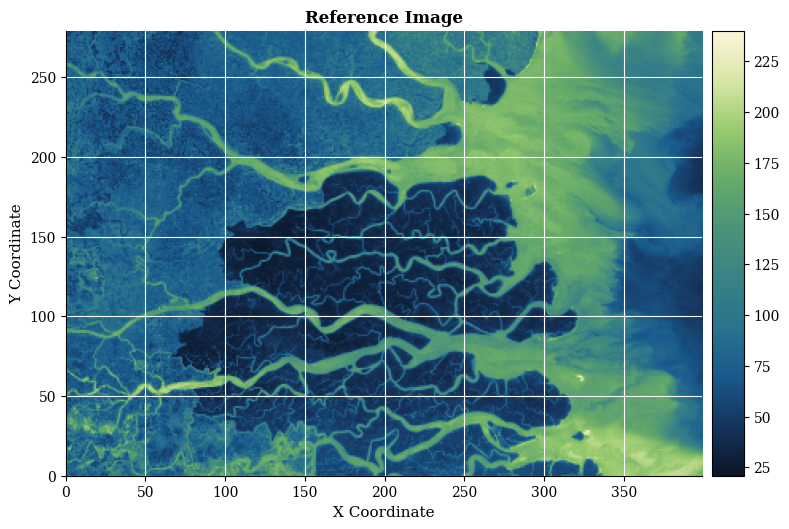

In [3]:
# We'll use spatialize's PlotStyle environment for easy formatting
with PlotStyle(theme='publication', cmap='navia') as style:
    fig, ax = plt.subplots(figsize=(8, 7))

    plot_colormap_data(
        reference_values,
        ax=ax,
        xi_locations=xi,
        griddata=False,
        cmap=style.cmap,
        extent=extent
    )

    ax.set_xlabel('X Coordinate', fontsize=11)
    ax.set_ylabel('Y Coordinate', fontsize=11)
    ax.set_title('Reference Image', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

### Create Sample Scenarios

We will simulate three different sampling scenarios, each with a different number of samples:

- **500 samples**: ~0.45% of the reference image
- **1000 samples**: ~0.89% of the reference image
- **3000 samples**: ~2.68% of the reference image

In [3]:
# Generate random samples of different sizes from reference data
np.random.seed(42)  # For reproducibility

sample_sizes = [500, 1000, 3000]
samples = {}

for i, n in enumerate(sample_sizes):
    # Randomly select n indices from the reference data
    indices = np.random.choice(len(reference_values), size=n, replace=False)
    
    # Extract points and values at these indices
    sample_points = xi[indices]
    sample_values = reference_values[indices]
    
    # Store in dictionary
    name = f'{n} samples'
    samples[name] = {
        'points': sample_points,
        'values': sample_values,
        'n_samples': n
    }
    
    print(f"Scenario {i+1}: {n} samples")
    print(f"  Value range: [{sample_values.min():.2f}, {sample_values.max():.2f}]")

Scenario 1: 500 samples
  Value range: [27.56, 198.33]
Scenario 2: 1000 samples
  Value range: [24.56, 205.44]
Scenario 3: 3000 samples
  Value range: [22.44, 212.37]


### Visualizing Input and Target Locations

Let's visualize where we have data (sample points) using the same colormap as the reference data.

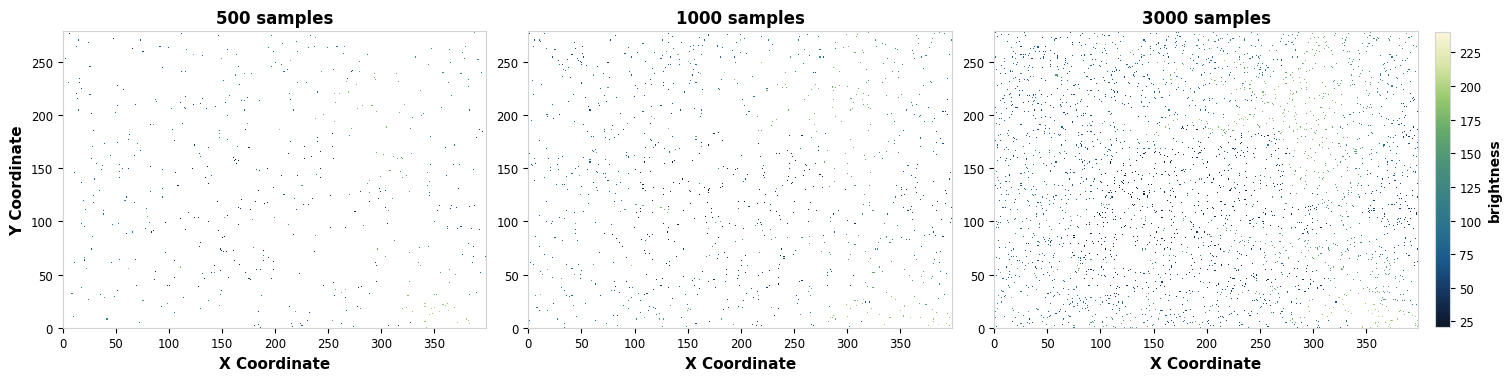

In [5]:
# Extract unique coordinates for grid structure
x_unique = np.sort(ref_data['X'].unique())
y_unique = np.sort(ref_data['Y'].unique())
nx, ny = len(x_unique), len(y_unique)

X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')
xi_grid = (X, Y)
ref_grid = ref_data.pivot(index='X', columns='Y', values='value').values

with PlotStyle(theme='white', cmap='navia') as style:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

    for idx, (name, sample_data) in enumerate(samples.items()):
        ax = axes[idx]

        # Create mask
        mask = np.ones((nx, ny), dtype=bool)
        for point in sample_data['points']:
            x_idx = int(point[0])
            y_idx = int(point[1])
            mask[x_idx, y_idx] = False

        # Create masked array: show reference values only at sample locations
        masked_data = np.ma.masked_array(ref_grid, mask=mask)

        im = ax.imshow(
            masked_data.T,
            origin='lower',
            extent=extent,
            cmap=style.cmap,
            vmin=vmin,
            vmax=vmax,
            interpolation='none'
        )

        ax.set_xlabel('X Coordinate', fontsize=11)
        if idx == 0:
            ax.set_ylabel('Y Coordinate', fontsize=11)
        ax.set_title(f'{name}', fontsize=12, fontweight='bold')

        if idx == 2:
            plt.colorbar(im, ax=ax, label='brightness', shrink=0.6, pad=0.04)

plt.show()

## Running Adaptive ESI

We'll now run the non-Gridded interpolation approach.
Note that a `parallelize` argument is employed. This allows full use of the computer's CPU, thereby speeding up the optimization and estimation processes in adaptive ESI, which is more complex than other ESI implementations.

In [4]:
# Run Adaptive ESI (nongriddata) for all scenarios
results_adaptive = {}

for name, sample_data in samples.items():
    print(f"\nRunning Adaptive ESI (nongriddata) for {name}...")

    result = esi_nongriddata(
        points=sample_data['points'],
        values=sample_data['values'],
        xi=xi,
        local_interpolator="adaptiveidw",
        parallelize=True,
        p_process="mondrian",
        n_partitions=100,
        alpha=0.7
    )

    estimation = result.estimation()
    precision = result.precision()

    results_adaptive[name] = {
        'estimation': estimation,
        'precision': precision,
        'result': result
    }

    print(f"  Estimation range: [{estimation.min():.2f}, {estimation.max():.2f}]")
    print(f"  Mean precision: {precision.mean():.4f}")


Running Adaptive ESI (nongriddata) for 500 samples...
finished 101% of 100 iterations ... 

done (elapsed time: 11s)
finished 100% of 100 iterations ... 

done (elapsed time:  7s)
  Estimation range: [27.56, 199.33]
  Mean precision: 280.6641

Running Adaptive ESI (nongriddata) for 1000 samples...
finished 101% of 100 iterations ... 

done (elapsed time: 41s)
finished 100% of 100 iterations ... 

done (elapsed time: 11s)
  Estimation range: [24.56, 205.44]
  Mean precision: 157.1039

Running Adaptive ESI (nongriddata) for 3000 samples...
finished 101% of 100 iterations ... 

done (elapsed time:  5m  3s)
finished 100% of 100 iterations ... 

done (elapsed time: 22s)
  Estimation range: [22.44, 212.37]
  Mean precision: 53.3252


### Comparison with Fixed ESI

Let's also run ESI IDW with a fixed exponent for comparison.

In [5]:
# Run Fixed ESI with exponent=2.0 for all scenarios (nongriddata)
results_fixed = {}

for name, sample_data in samples.items():
    print(f"\nRunning Fixed ESI (nongriddata) for {name}...")

    result = esi_nongriddata(
        points=sample_data['points'],
        values=sample_data['values'],
        xi=xi,
        local_interpolator="idw",
        p_process="mondrian",
        n_partitions=100,
        alpha=0.7,
        exponent=2.0
    )

    estimation = result.estimation()
    precision = result.precision()

    results_fixed[name] = {
        'estimation': estimation,
        'precision': precision,
        'result': result
    }

    print(f"  Estimation range: [{estimation.min():.2f}, {estimation.max():.2f}]")
    print(f"  Mean precision: {precision.mean():.4f}")


Running Fixed ESI (nongriddata) for 500 samples...
finished 100% of 100 iterations ... 

done (elapsed time: 23s)
  Estimation range: [27.56, 198.33]
  Mean precision: 60.9845

Running Fixed ESI (nongriddata) for 1000 samples...
finished 100% of 100 iterations ... 

done (elapsed time: 38s)
  Estimation range: [24.56, 205.44]
  Mean precision: 41.9716

Running Fixed ESI (nongriddata) for 3000 samples...
finished 100% of 100 iterations ... 

done (elapsed time:  1m 39s)
  Estimation range: [22.44, 212.37]
  Mean precision: 23.9697


## Adaptive ESI Results Across Scenarios

Now let's analyze the ESI estimates across all scenarios.

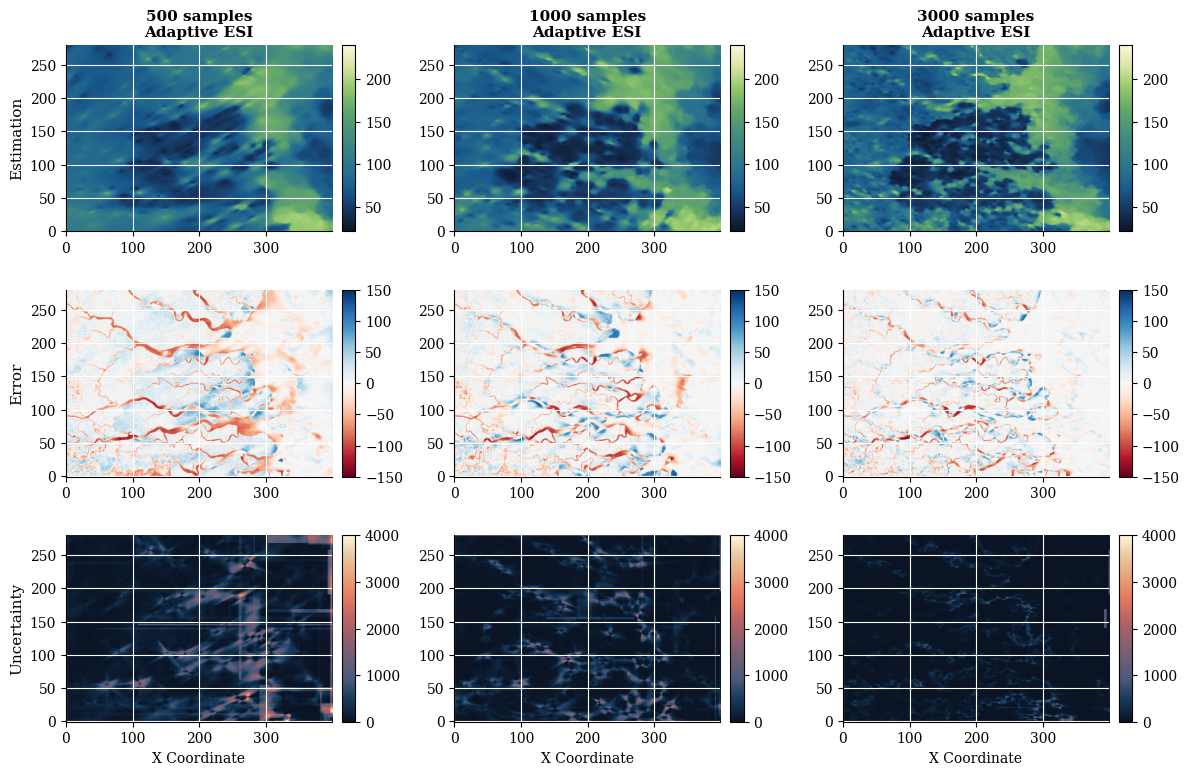

In [9]:
with PlotStyle(theme='publication', cmap='navia', precision_cmap='lipari') as style:
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))

    for col_idx, (name, result_data) in enumerate(results_adaptive.items()):
        # Row 0: Estimation
        plot_colormap_data(result_data['estimation'], xi_locations=xi,
                           ax=axes[0, col_idx],
                           griddata=False, cmap=style.cmap,
                           vmin=vmin, vmax=vmax)
        
        axes[0, col_idx].set_title(f'{name}\nAdaptive ESI', fontsize=11, fontweight='bold')
        if col_idx == 0:
            axes[0, col_idx].set_ylabel('Estimation', fontsize=11)

        # Row 1: Error
        error = (result_data['estimation'] - reference_values)#/(reference_values_nongrid.min()-reference_values_nongrid.max())
        plot_colormap_data(error, xi_locations=xi,
                           ax=axes[1, col_idx],
                           griddata=False, cmap='RdBu',
                           vmin=-150, vmax=150,
                           )

        if col_idx == 0:
            axes[1, col_idx].set_ylabel('Error', fontsize=11)

        # Row 2: Precision
        plot_colormap_data(result_data['precision'], xi_locations=xi,
                           ax=axes[2, col_idx],
                           griddata=False, cmap=style.precision_cmap,
                           vmin=0, vmax=4000)
        
        axes[2, col_idx].set_xlabel('X Coordinate', fontsize=10)
        if col_idx == 0:
            axes[2, col_idx].set_ylabel('Uncertainty', fontsize=11)

plt.tight_layout()
plt.show()

## Adaptive vs Fixed ESI Comparison

Detailed comparison for the 1% scenario.

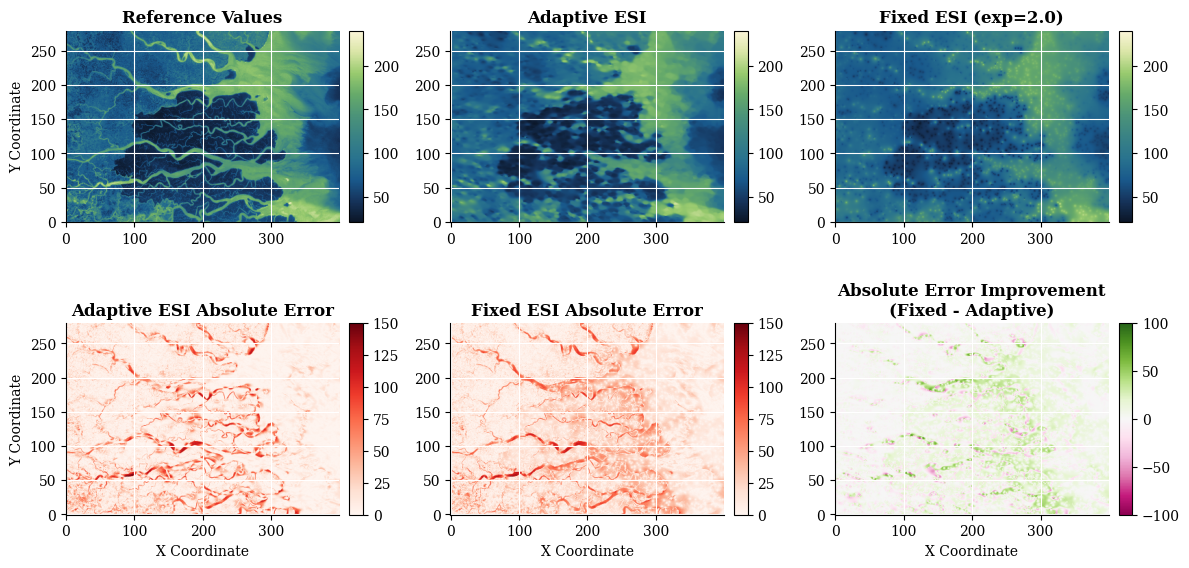

In [25]:
scenario_name = '3000 samples'

with PlotStyle(theme='publication', cmap='navia', precision_cmap='lipari') as style:
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    # Row 1: Reference, Adaptive, Fixed
    # Reference values
    plot_colormap_data(reference_values, xi_locations=xi,
                            ax=axes[0, 0],
                            griddata=False, cmap=style.cmap)
    
    axes[0, 0].set_title('Reference Values', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Y Coordinate', fontsize=10)

    # Adaptive ESI estimation
    plot_colormap_data(results_adaptive[scenario_name]['estimation'],
                       xi_locations=xi, ax=axes[0, 1],
                       griddata=False, cmap=style.cmap,
                       vmin=vmin, vmax=vmax)
    
    axes[0, 1].set_title('Adaptive ESI', fontsize=12, fontweight='bold')

    # Fixed ESI estimation
    plot_colormap_data(results_fixed[scenario_name]['estimation'],
                       xi_locations=xi, ax=axes[0, 2],
                       griddata=False, cmap=style.cmap,
                       vmin=vmin, vmax=vmax)
   
    axes[0, 2].set_title('Fixed ESI (exp=2.0)', fontsize=12, fontweight='bold')

    # Row 2: Errors and Improvement
    # Adaptive error
    error_adaptive = np.abs(results_adaptive[scenario_name]['estimation'] - reference_values)
    plot_colormap_data(error_adaptive, xi_locations=xi,
                       ax=axes[1,0], griddata=False, cmap='Reds', vmax=150)

    axes[1, 0].set_title('Adaptive ESI Absolute Error', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('X Coordinate', fontsize=10)
    axes[1, 0].set_ylabel('Y Coordinate', fontsize=10)

    # Fixed error
    error_fixed = np.abs(results_fixed[scenario_name]['estimation'] - reference_values)
    plot_colormap_data(error_fixed, xi_locations=xi,
                       ax=axes[1,1], griddata=False, cmap='Reds', vmax=150)

    axes[1, 1].set_title('Fixed ESI Absolute Error', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('X Coordinate', fontsize=10)

    # Error improvement (Fixed - Adaptive)
    error_improvement = error_fixed - error_adaptive

    plot_colormap_data(error_improvement, xi_locations=xi,
                       ax=axes[1,2], griddata=False, cmap='PiYG',
                       vmin=-100, vmax=100)

    axes[1, 2].set_title('Absolute Error Improvement\n(Fixed - Adaptive)', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('X Coordinate', fontsize=10)

plt.tight_layout()
plt.show()

## Quantitative Performance Metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare metrics comparison
metrics_data = []

for name in samples.keys():
    adaptive_est = results_adaptive[name]['estimation']
    fixed_est = results_fixed[name]['estimation']

    # Adaptive ESI metrics
    metrics_data.append({
        'Scenario': name,
        'Method': 'Adaptive ESI',
        'MAE': mean_absolute_error(reference_values, adaptive_est),
        'RMSE': np.sqrt(mean_squared_error(reference_values, adaptive_est)),
        'R²': r2_score(reference_values, adaptive_est)
    })

    # Fixed ESI metrics
    metrics_data.append({
        'Scenario': name,
        'Method': 'Fixed ESI',
        'MAE': mean_absolute_error(reference_values, fixed_est),
        'RMSE': np.sqrt(mean_squared_error(reference_values, fixed_est)),
        'R²': r2_score(reference_values, fixed_est)
    })

metrics_df = pd.DataFrame(metrics_data)

print("\nPerformance Comparison Across Scenarios:")
print("="*55)
print(metrics_df.to_string(index=False))
print("="*55)


Performance Comparison Across Scenarios:
    Scenario       Method       MAE      RMSE       R²
 500 samples Adaptive ESI 20.786378 29.913122 0.590172
 500 samples    Fixed ESI 22.807091 31.040487 0.558699
1000 samples Adaptive ESI 17.940491 28.717413 0.622281
1000 samples    Fixed ESI 21.136097 29.295139 0.606930
3000 samples Adaptive ESI 14.328492 23.941884 0.737460
3000 samples    Fixed ESI 18.872231 26.049611 0.689200


## Summary

This notebook demonstrated:

- ✓ Using `esi_nongriddata()` with real water level data
- ✓ Comparison across three different sampling densities (156, 780, 3900 points)
- ✓ Adaptive ESI vs Fixed ESI performance comparison
- ✓ Spatial error and precision analysis
- ✓ Effect of sample density on performance
- ✓ Practical visualization techniques for scattered data

**Key Takeaways:**

- Adaptive ESI consistently outperforms Fixed ESI across all sampling densities, based on MAE and RMSE metrics
- Precision values help identify regions of high uncertainty
- Performance improves with increased sample density for both methods
- Adaptive ESI shows particular advantages in spatially heterogeneous regions
- No manual parameter tuning required for Adaptive ESI

**Recommendations:**

- Use Adaptive ESI when working with spatially heterogeneous data
- For sparse sampling, both methods struggle but Adaptive ESI maintains better performance
- Precision maps can guide additional sampling efforts by identifying high-uncertainty regions

## References

> Egaña, Á.F., Valenzuela, M.J., Maleki, M. et al. *Adaptive ensemble spatial analysis*.
> Scientific Reports **15**, 26599 (2025).
> https://doi.org/10.1038/s41598-025-08844-z